# Imports

In [7]:
import json
import locale
import os
from datetime import datetime

import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from stock_modules.stock_transform import (create_batch_xy,
                                           create_transformer_onehot_xy)

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model

from stock_modules.stock_ml import (create_transformer_model,
                                    MultiSoftmaxLoss, MultiAccuracy)

from invest_strategies import (calculate_optimal_invest_strategy,
                               calculate_profit_on_invest_strategy,
                               strategy_mask_from_direction_model)

import matplotlib.pyplot as plt
%matplotlib widget

from stock_modules.stock_plot import plot_mask_and_data

# Constants

In [8]:
ENCODING = locale.getpreferredencoding()
DF_PATH = "HEL_12-10-21to08-11-23.csv"
MODEL_SERIAL = None
SELECTED_TICKERS_PATH = "./TICKERS_TO_FOLLOW.json"

TEST_FRAC = 0.2
PREDICT_PRICES = False

# Data Import

In [9]:
SELECTED_TICKERS = json.load(open(SELECTED_TICKERS_PATH,
                                  "r", encoding=ENCODING))
DATAFRAME = pd.read_csv(DF_PATH, encoding=ENCODING)

DATAFRAME.set_index("date", inplace=True)
HAS_TIMEDELTA = "Time Delta" in DATAFRAME.columns

# ind transformation tells the label of each index in the np_arr_test
IND_CONVERSION = {i: ticker for i, ticker in enumerate(DATAFRAME.columns) if ticker in SELECTED_TICKERS}
IND_CONVERSION = {i: ticker for i, ticker in enumerate(IND_CONVERSION.values())}

print("Selected tickers: \n", SELECTED_TICKERS)
print("Dataframe columns: \n", DATAFRAME.columns)
print("Dataframe shape: ", DATAFRAME.shape)
print("Dataframe head: \n", DATAFRAME.head(2))
print(f"Index conversion: \n {IND_CONVERSION}")

Selected tickers: 
 ['ALBBV.HE', 'CGCBV.HE', 'EQV1V.HE', 'KNEBV.HE', 'ORNBV.HE', 'OLVAS.HE', 'DETEC.HE', 'PON1V.HE', 'ORNAV.HE', 'VALMT.HE', 'NESTE.HE', 'HUH1V.HE', 'REG1V.HE', 'VAIAS.HE']
Dataframe columns: 
 Index(['REG1V.HE', 'NESTE.HE', 'ORNBV.HE', 'KNEBV.HE', 'OLVAS.HE', 'HUH1V.HE',
       'DETEC.HE', 'ORNAV.HE', 'CGCBV.HE', 'VAIAS.HE', 'ALBBV.HE', 'VALMT.HE',
       'EQV1V.HE', 'PON1V.HE'],
      dtype='object')
Dataframe shape:  (4389, 14)
Dataframe head: 
                       REG1V.HE   NESTE.HE   ORNBV.HE   KNEBV.HE   OLVAS.HE  \
date                                                                         
2021-10-12 07:00:00  55.950001  41.820000  35.689999  60.220001  53.099998   
2021-10-12 08:00:00  55.799999  41.720001  35.630001  60.419998  53.299999   

                      HUH1V.HE  DETEC.HE   ORNAV.HE   CGCBV.HE   VAIAS.HE  \
date                                                                        
2021-10-12 07:00:00  38.529999      23.0  38.049999  43.139999  

# Data Treatment

In [10]:
test_begin_idx = int(DATAFRAME.shape[0] * (1 - TEST_FRAC))

if PREDICT_PRICES:
    scaler = MinMaxScaler()

    scaler.fit(DATAFRAME.iloc[:test_begin_idx, :])
    transformed_df = pd.DataFrame(scaler.transform(DATAFRAME), columns=DATAFRAME.columns, index=DATAFRAME.index)
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        if isinstance(df, pd.DataFrame):
            return pd.DataFrame(scaler.inverse_transform(df), columns=df.columns, index=df.index)
        elif isinstance(df, np.ndarray):
            return scaler.inverse_transform(df)

# If we are predicting the up/down, we create a dataframe where we subtract the previous value from the current value
else:
    # Do not diff the Time Delta column
    df = DATAFRAME.copy()
    if HAS_TIMEDELTA:
        td_col = df["Time Delta"]
        df.drop("Time Delta", axis=1, inplace=True)
    transformed_df = df.diff()
    # The first row is NaN, so lets copy the second row there
    transformed_df.iloc[0, :] = transformed_df.iloc[1, :]
    # Add back the Time Delta column
    if HAS_TIMEDELTA:
        transformed_df["Time Delta"] = td_col
        # Make Time Delta the first column
        cols = transformed_df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        transformed_df = transformed_df[cols]
    transformed_np_arr = transformed_df.to_numpy()

    def inverse_transform(df):
        return df

print("Transformed df: \n", transformed_df.head(2))
print("Transformed df shape: ", transformed_df.shape)

Transformed df: 
                      REG1V.HE  NESTE.HE  ORNBV.HE  KNEBV.HE  OLVAS.HE  \
date                                                                    
2021-10-12 07:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   
2021-10-12 08:00:00 -0.150002 -0.099998 -0.059998  0.199997  0.200001   

                     HUH1V.HE  DETEC.HE  ORNAV.HE  CGCBV.HE  VAIAS.HE  \
date                                                                    
2021-10-12 07:00:00  0.030003       0.0       0.0  0.360001 -0.200001   
2021-10-12 08:00:00  0.030003       0.0       0.0  0.360001 -0.200001   

                     ALBBV.HE  VALMT.HE  EQV1V.HE  PON1V.HE  
date                                                         
2021-10-12 07:00:00  0.099998  0.139999       0.1  0.049999  
2021-10-12 08:00:00  0.099998  0.139999       0.1  0.049999  
Transformed df shape:  (4389, 14)


# Model Optimization

Epoch 1/100
82/82 [==============================] - ETA: 0s - loss: 8.8968 - multi_accuracy_1: 0.4518

/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/training.py:2699: UserWarning: Metric MultiAccuracy implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


82/82 [==============================] - 23s 164ms/step - loss: 8.8968 - multi_accuracy_1: 0.4518 - val_loss: 12.0767 - val_multi_accuracy_1: 0.3972
Epoch 2/100
82/82 [==============================] - 12s 151ms/step - loss: 11.8454 - multi_accuracy_1: 0.3431 - val_loss: 12.0767 - val_multi_accuracy_1: 0.3296
Epoch 3/100
82/82 [==============================] - 12s 149ms/step - loss: 11.8454 - multi_accuracy_1: 0.3131 - val_loss: 12.0767 - val_multi_accuracy_1: 0.3067
Epoch 4/100
82/82 [==============================] - 12s 152ms/step - loss: 11.8454 - multi_accuracy_1: 0.2991 - val_loss: 12.0767 - val_multi_accuracy_1: 0.2952
Epoch 5/100
82/82 [==============================] - 12s 150ms/step - loss: 11.8454 - multi_accuracy_1: 0.2910 - val_loss: 12.0767 - val_multi_accuracy_1: 0.2882
Epoch 6/100
82/82 [==============================] - 12s 152ms/step - loss: 11.8454 - multi_accuracy_1: 0.2857 - val_loss: 12.0767 - val_multi_accuracy_1: 0.2836
Epoch 7/100
82/82 [======================

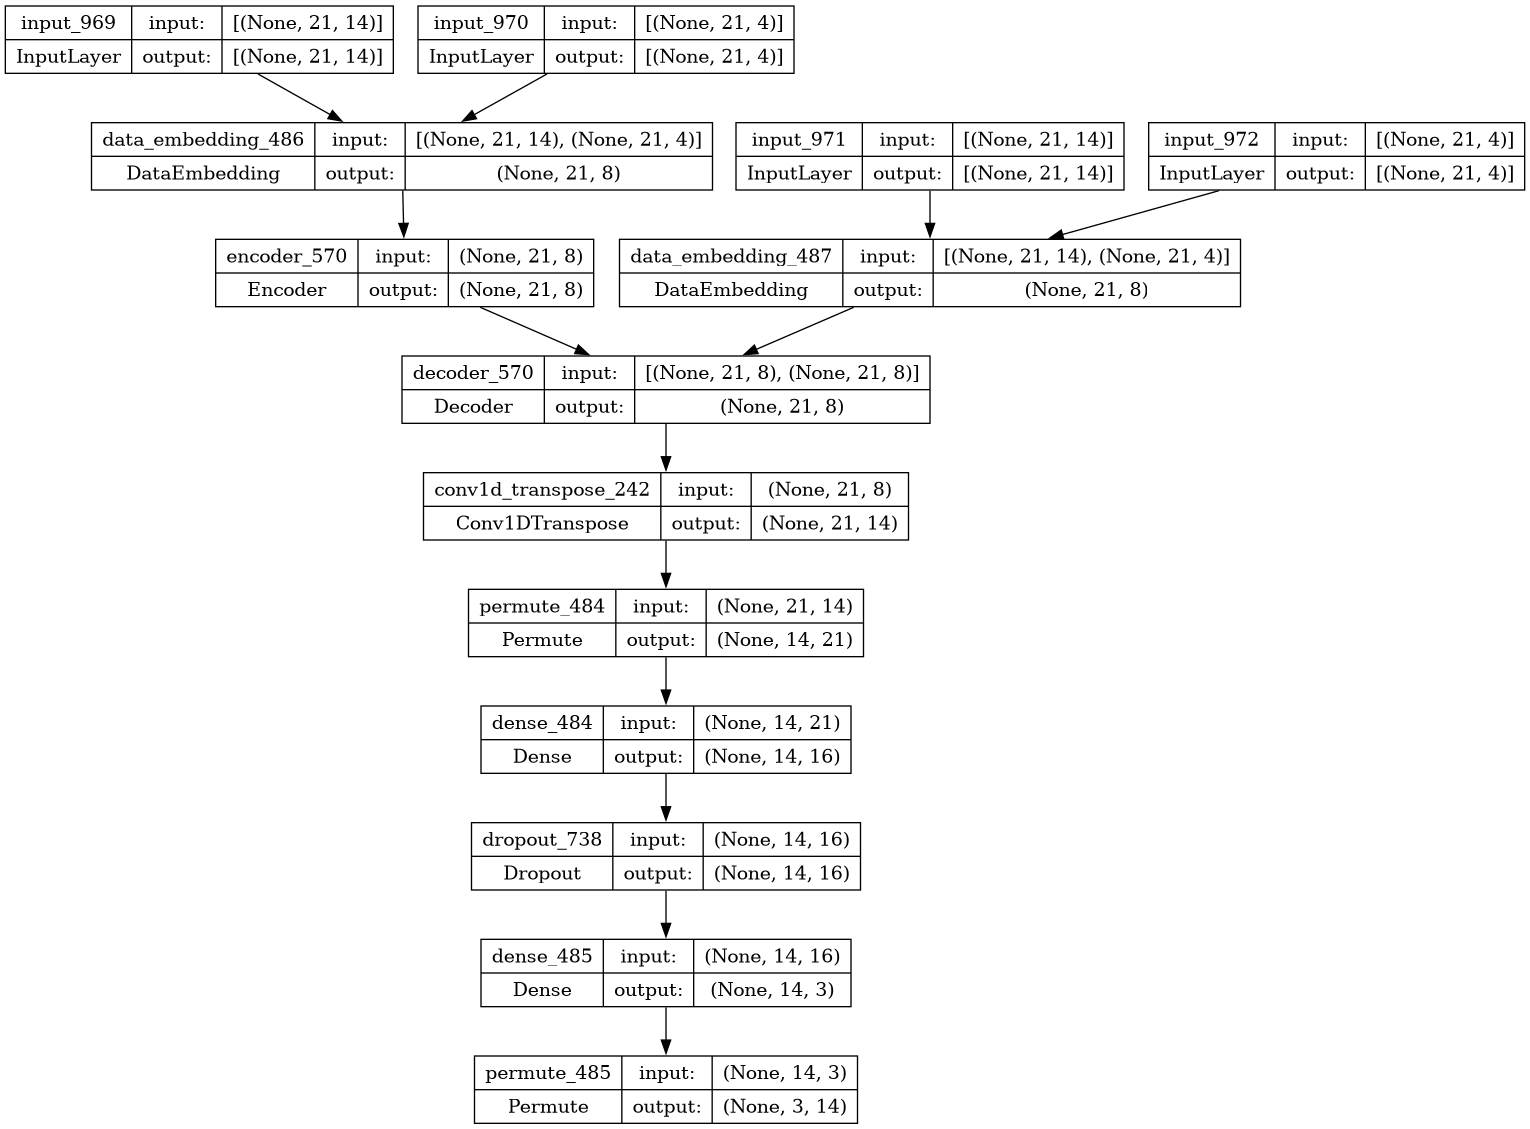

In [11]:
if not os.path.exists("./models/"):
    os.makedirs("./models/")

METRICS = [MultiAccuracy()]
CALLBACKS = [keras.callbacks.EarlyStopping(patience=10,
                                           restore_best_weights=True)]
CLASS_FIRST = True

if MODEL_SERIAL is None:
    counter = 0
    RESUME = 0

    for memory_length in [20]:
        if PREDICT_PRICES:
            OUTPUT_SCALE = (0,1)
            x, y = create_batch_xy(
                        memory_length,
                        transformed_np_arr,
                        overlap=True,
                        y_updown=False,
                        diff_data=True,
                        output_scale=OUTPUT_SCALE)
        else:
            x, x_ts, y = create_transformer_onehot_xy(
                                memory_length,
                                transformed_np_arr,
                                DATAFRAME.to_numpy(),
                                DATAFRAME.index.to_numpy(),
                                0.01)

        split_idx = int(x.shape[0] * (1 - TEST_FRAC))

        x_train = x[:split_idx,:,:]
        x_ts_train = x_ts[:split_idx,:,:]
        y_train = y[:split_idx,:,:]

        x_test = x[split_idx:,:,:]
        x_ts_test = x_ts[split_idx:,:,:]
        y_test = y[split_idx:,:,:]

        if CLASS_FIRST:
            y_train = tf.transpose(y_train, (0,2,1))
            y_test = tf.transpose(y_test, (0,2,1))

        for head_size in [32,16,8]:
            for num_heads in [32,16,8]:
                for ff_dim in [64,32,16]:
                    for num_transformer_blocks in [4,2,1]:
                        for mlp_units in [64,32,16]:
                            if counter < RESUME:
                                counter = counter + 1
                                continue
                            
                            serial = "transformer_model_" \
                                + datetime.now().strftime("%Y%m%d%H%M%S")
                            model_dict = {
                                "serial": serial,
                                "memory_length": memory_length,
                                "head_size": head_size,
                                "num_heads": num_heads,
                                "ff_dim": ff_dim,
                                "num_transformer_blocks": num_transformer_blocks,
                                "mlp_units": mlp_units
                            }

                            model = create_transformer_model(
                                    m=memory_length+1,
                                    n=len(SELECTED_TICKERS),
                                    output_dim=3,
                                    head_size=head_size,
                                    num_heads=num_heads,
                                    ff_dim=ff_dim,
                                    num_transformer_blocks=num_transformer_blocks,
                                    mlp_units=(mlp_units,),
                                    class_first=CLASS_FIRST
                                )
                            

                            model.compile(optimizer=keras.optimizers.Adam(),
                                        loss=MultiSoftmaxLoss(),
                                        metrics=METRICS)

                            model.fit(x = (x_train,x_ts_train,x_train,x_ts_train),
                                    y = y_train,
                                    batch_size=32,
                                    epochs=100,
                                    validation_split=0.25,
                                    callbacks=CALLBACKS)
                            
                            model.save("./models/"+serial+".keras")

                            model_dict.update(model.evaluate(
                                        x = (x_test,x_ts_test,x_test,x_ts_test),
                                        y = y_test,
                                        batch_size=32,
                                        workers=4,
                                        use_multiprocessing=True,
                                        return_dict=True
                                    )
                                )
                            
                            if os.path.exists("./transformer_results.json"):
                                with open("./transformer_results.json", "r",
                                        encoding=ENCODING) as json_file:
                                    model_list = json.load(json_file)
                            else:
                                model_list = [model_dict]
                            
                            with open("./transformer_results.json", "w",
                                    encoding=ENCODING) as json_file:
                                json.dump(model_list, json_file)

    if os.path.exists("./transformer_results.json"):
        with open("./transformer_results.json", "r",
                  encoding=ENCODING) as json_file:
            model_list = json.load(json_file)
    else:
        model_list = [{}]
    
    model_df = pd.DataFrame.from_dict(model_list)
    model_df.to_excel("./transformer_results.xlsx")
else:
    with open("./transformer_results.json", "r",
              encoding=ENCODING) as json_file:
        model_list = json.load(json_file)
    model_dict = next(item for item in model_list
                      if item["serial"] == MODEL_SERIAL)

    memory_length = int(model_dict["memory_length"])

    if PREDICT_PRICES:
        OUTPUT_SCALE = (0,1)
        x, y = create_batch_xy(
                    memory_length,
                    transformed_np_arr,
                    overlap=True,
                    y_updown=False,
                    diff_data=True,
                    output_scale=OUTPUT_SCALE)
    else:
        x, x_ts, y = create_transformer_onehot_xy(
                            memory_length,
                            transformed_np_arr,
                            DATAFRAME.to_numpy(),
                            DATAFRAME.index.to_numpy(),
                            0.01)

    split_idx = int(x.shape[0] * (1 - TEST_FRAC))

    x_train = x[:split_idx,:,:]
    x_ts_train = x_ts[:split_idx,:,:]
    y_train = y[:split_idx,:,:]

    x_test = x[split_idx:,:,:]
    x_ts_test = x_ts[split_idx:,:,:]
    y_test = y[split_idx:,:,:]

    if CLASS_FIRST:
        y_train = tf.transpose(y_train, (0,2,1))
        y_test = tf.transpose(y_test, (0,2,1))

    model = keras.models.load_model("./models/" + MODEL_SERIAL + ".keras")

plot_model(
        model,
        to_file="./figures/transformer_model_plot.png",
        show_shapes=True,
        show_layer_names = True
    )



# Benchmark

## Accuracy

In [13]:
y_pred = model([x_test, x_ts_test, x_test, x_ts_test], training=False)
print("Y_pred: \n", y_pred)
print("Y_test: \n", y_test)

for stock_idx in range(y_pred.shape[2] if CLASS_FIRST else y_pred.shape[1]):
    if CLASS_FIRST:
        direction_preds = y_pred[:,:,stock_idx]
        direction_true = y_test[:,:,stock_idx]
    else:
        direction_preds = y_pred[:,stock_idx,:]
        direction_true = y_test[:,stock_idx,:]

    accuracy = \
        np.sum(direction_preds == direction_true) / direction_preds.shape[0]
    print(f"""
            Up/Down/Flat accuracy for stock {IND_CONVERSION[stock_idx]}:
            {accuracy}
            """
        )

Y_pred: 
 tf.Tensor(
[[[0.29340312 0.2569788  0.29082996 ... 0.16004698 0.21647684 0.2937286 ]
  [2.3515968  2.7480996  1.8522009  ... 1.3358694  1.7770575  2.5484314 ]
  [0.28938636 0.33966392 0.11452262 ... 0.08373828 0.24928674 0.324595  ]]

 [[0.23015325 0.35680622 0.09976805 ... 0.13395987 0.28017747 0.35473055]
  [2.3040075  2.9668436  1.5699586  ... 1.4319216  1.8518115  2.7408357 ]
  [0.26561773 0.30617243 0.14318319 ... 0.08938296 0.2763354  0.30748072]]

 [[0.3063454  0.27490884 0.15584575 ... 0.13066338 0.21934335 0.2651564 ]
  [2.4480639  2.904065   1.6985222  ... 1.2028952  1.8211173  2.569797  ]
  [0.23098941 0.26355594 0.15237725 ... 0.1444553  0.24517244 0.28292486]]

 ...

 [[0.26652652 0.30035418 0.22862072 ... 0.14734337 0.22625704 0.30323762]
  [2.3630042  2.9375038  1.7125874  ... 1.3819968  1.800588   2.6031694 ]
  [0.2804425  0.29186288 0.1313832  ... 0.08112718 0.2494541  0.310271  ]]

 [[0.28912234 0.3262136  0.16566332 ... 0.09062979 0.24529527 0.32233125]
  [

## Profitability

In [14]:
# Calculate profit by optimal strategy (theoretical) vs using model to predict
test_sz = int(DATAFRAME.shape[0] * TEST_FRAC)
df_test = DATAFRAME.iloc[-test_sz:,:].copy()
if HAS_TIMEDELTA:
    df_test.drop("Time Delta", axis=1, inplace=True)
np_arr_test = df_test.to_numpy()
print("np_arr_test data shape: ", np_arr_test.shape)

optimal_trading_mask = calculate_optimal_invest_strategy(np_arr_test)
print(f"Optimal mask 3rd stock: \n {optimal_trading_mask[:,2]}")
profit_optimal = calculate_profit_on_invest_strategy(np_arr_test,
                                                     optimal_trading_mask)
print(f"Optimal strategy matrix shape: {optimal_trading_mask.shape}")
print(f"Profit by optimal strategy on test data: {profit_optimal}")

# To calculate the mask for the model, we need to give the data in the same format as it was trained in
transformed_df_test = transformed_df.iloc[-test_sz:,:]
transformed_np_arr_test = transformed_df_test.to_numpy()
print("transformed_np_arr_test data shape: ", transformed_np_arr_test.shape)
print(transformed_np_arr_test[0:2,:])
prediction_trading_mask = \
    strategy_mask_from_direction_model(transformed_np_arr_test,
                                       memory_length, model)

if HAS_TIMEDELTA:
    prediction_trading_mask = prediction_trading_mask[:,1:]

print(f"Prediction mask 3rd stock: \n {prediction_trading_mask[:,2]}")
if HAS_TIMEDELTA:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test[:,1:],
                                            prediction_trading_mask)
else:
    profit_pred_model = \
        calculate_profit_on_invest_strategy(np_arr_test,
                                            prediction_trading_mask)

print(f"Prediction strategy matrix shape: {prediction_trading_mask.shape}")
print(
    f"Profit by predicting the next hour using the model: {profit_pred_model}")

np_arr_test data shape:  (877, 14)
Optimal mask 3rd stock: 
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

ValueError: in user code:

    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/sergiovaneg/miniforge3/envs/stonks/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 219, in assert_input_compatibility
        raise ValueError(

    ValueError: Layer "model_242" expects 4 input(s), but it received 1 input tensors. Inputs received: [<tf.Tensor 'IteratorGetNext:0' shape=(None, 20, 14) dtype=float32>]


## Plotting

In [ ]:
stock_indices = np.random.choice(np.arange(len(IND_CONVERSION)), 4,
                                 replace=False)
part_mask = prediction_trading_mask[:,stock_indices]

if HAS_TIMEDELTA:
    part_price = np_arr_test[:,1:][:,stock_indices]
else:
    part_price = np_arr_test[:,stock_indices]

ind_conversion = {si : IND_CONVERSION[i] for si, i in enumerate(stock_indices)}
plot_mask_and_data(part_mask, part_price, ind_conversion)